## Продвинутое машинное обучение: 
### Домашнее задание 2


In [239]:
import pickle
import datetime
from collections import defaultdict, Counter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from sklearn.linear_model import LogisticRegression

**Загрузим данные**

Прочитайте и проанализируйте данные, выберите турниры, в которых есть данные о составах команд и повопросных результатах (поле mask в results.pkl). Для унификации предлагаю:
- взять в тренировочный набор турниры с dateStart из 2019 года; 
- в тестовый — турниры с dateStart из 2020 года.


In [64]:
%%time
with open('./players.pkl', 'rb') as players_pickle:
    players = pd.DataFrame(pickle.load(players_pickle)).T
    
with open('./results.pkl', 'rb') as results_pickle:
    results = pickle.load(results_pickle)

with open('./tournaments.pkl', 'rb') as tournaments_pickle:
    tournaments = pickle.load(tournaments_pickle)

CPU times: user 31.5 s, sys: 7.87 s, total: 39.4 s
Wall time: 41.8 s


In [417]:
train_tours = list()
test_tours = list()

train_year = 2019
test_year = 2020

# Проверка наличия статистики по ответам у все команд
def check_team_results(result):
    teams = list()
    quest_num = set()
    
    for team in result:
        
        if not team.get('mask', None) or not team.get('mask', None):
            return None
        quest_num.add(len(team.get('mask', None)))
        uniq_labels = set(team.get('mask', None))
        if len(uniq_labels) > 2:
            continue
        
        if not all([el.isnumeric() for el in uniq_labels]):
            continue
                
        # Будем добавлять в словарь только необходимую нам информацию
        team_dict = dict()
        team_dict['id'] = team['team']['id']
        team_dict['name'] = team['team']['name']
        team_dict['position'] = team['position']
        team_dict['num_quest'] = len(team['mask'])
        team_dict['mask'] = team['mask']
        team_dict['members'] = [member['player']['id'] for member in team['teamMembers']]
                
        teams.append(team_dict)
    if len(quest_num) != 1:
        return None
    return teams
        
        
for tournament_idx in tqdm(results):
    if not results[tournament_idx] or len(results[tournament_idx]) < 1:
        continue
    
    # Выберем только соревнования нужных нам лет
    tournament_year = pd.to_datetime(tournaments[tournament_idx]['dateStart']).year
    if tournament_year not in [2019, 2020]:
        continue
    
    # Отфильтруем соревнования без масок ответов и команды у которых есть неизвестные значения в ответах
    teams = check_team_results(results[tournament_idx])
    if teams:
        results_clean_teams[tournament_idx] = teams
    else:
        continue
        
    # Переформируем данные по соревнованиям оставив только самое необходимое
    tournament = dict()
    tournament['id'] = tournament_idx
    tournament['teams'] = teams
    
    # Распределение по выборкам
    if tournament_year == train_year:
        train_tours.append(tournament)
    elif tournament_year == test_year:
        test_tours.append(tournament)
    
            

100%|██████████| 5528/5528 [00:06<00:00, 895.18it/s] 


In [418]:
print(f'Количество соревнований в обучающей выборке: {len(train_tours)}')
print(f'Количество соревнований в тестовой выборке: {len(test_tours)}')

Количество соревнований в обучающей выборке: 601
Количество соревнований в тестовой выборке: 152


Сформируем основные статистики по каждому из игроков

**Анализ данных**

In [162]:
%%time
quest_num = list()
num_teams_tournament = list()

member_teams = defaultdict(set)
num_members = list()

correct_answers_num = list()
wrong_answers_num = list()
correct_answers_ratio = list()
wrong_answers_ratio = list()


for tournament in train_tours:
    quest_num.append(len(tournament['teams'][0]['mask']))
    num_teams_tournament.append(len(tournament['teams']))
    for team in tournament['teams']:
        answers = np.array(list(team['mask'])).astype('int')
        correct_answers_num.append(answers.sum())
        wrong_answers_num.append(len(answers) - correct_answers_num[-1])
        correct_answers_ratio.append(answers.mean())
        wrong_answers_ratio.append(1 - correct_answers_ratio[-1])
        num_members.append(len(team['members']))
        
    
        for member in team['members']:
            member_teams[member].add(team['id'])

member_team_num = [len(teams_list) for teams_list in member_teams.values()]

CPU times: user 2.29 s, sys: 46.6 ms, total: 2.34 s
Wall time: 2.4 s


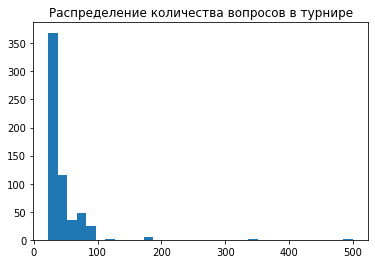

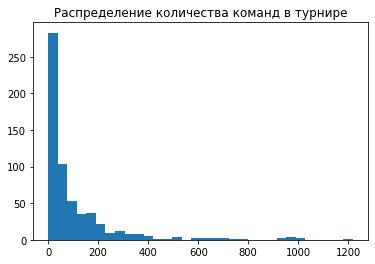

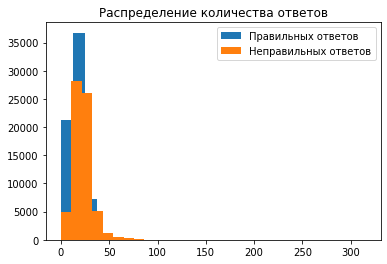

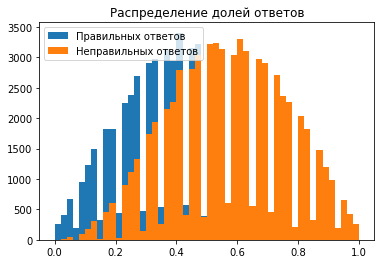

In [163]:
 

plt.hist(quest_num, bins=32)
plt.title('Распределение количества вопросов в турнире')
plt.show()

plt.hist(num_teams_tournament, bins=32)
plt.title('Распределение количества команд в турнире')
plt.show()

plt.hist(correct_answers_num, label='Правильных ответов', bins=25)
plt.hist(wrong_answers_num, label='Неправильных ответов', bins=25)
plt.title('Распределение количества ответов')
plt.legend()
plt.show()

# Расчески какие-то, связано видимо с тем что в среднем количество вопросов в среднем достаточно близко
plt.hist(correct_answers_ratio, label='Правильных ответов', bins=50)
plt.hist(wrong_answers_ratio, label='Неправильных ответов', bins=50)
plt.title('Распределение долей ответов')
plt.legend()
plt.show()

In [164]:
statistics = pd.DataFrame([])
for name, statistic in [
    ('Доля правильных ответов', correct_answers_ratio),
    ('Доля неправильных ответов', wrong_answers_ratio),
    ('Количество игроков в команде', num_members),
    ('Количество команд в турнире', num_teams_tournament),
    ('Количество вопросов в турнире', num_teams_tournament),
]:
    t = pd.Series(statistic, name=name).describe()
    statistics[name] = t
    
print("Основные статистики по распределениям некоторых параметров из обучающей выборки")
statistics.drop('count')

Основные статистики по распределениям некоторых параметров из обучающей выборки


,Доля правильных ответов,Доля неправильных ответов,Количество игроков в команде,Количество команд в турнире,Количество вопросов в турнире
mean,0.429010,0.570990,5.152816,110.623960,110.623960
std,0.191917,0.191917,1.219066,170.615557,170.615557
min,0.000000,0.000000,0.000000,1.000000,1.000000
25%,0.277778,0.430556,4.000000,22.000000,22.000000
50%,0.416667,0.583333,6.000000,45.000000,45.000000
75%,0.569444,0.722222,6.000000,124.000000,124.000000
max,1.000000,1.000000,13.000000,1218.000000,1218.000000


### Постройте baseline-модель на основе линейной или логистической регрессии, которая будет обучать рейтинг-лист игроков.
Замечания и подсказки:
 - повопросные результаты — это фактически результаты броска монетки, и их предсказание скорее всего имеет отношение к бинарной классификации;
 - в разных турнирах вопросы совсем разного уровня сложности, поэтому модель должна это учитывать;
 - скорее всего, модель должна будет явно обучать не только силу каждого игрока, но и сложность каждого вопроса;
 - для baseline-модели можно забыть о командах и считать, что повопросные результаты команды просто относятся к каждому из её игроков.



Построим обучающую выборку, в качестве обучения будет использоваться one-hot вектор (идентификатор игрока, идентификатор вопроса)

In [166]:
from scipy import sparse

In [362]:
%%time
members_set = list(member_teams.keys())
member_to_idx = dict(zip(members_set, range(len(members_set))))
idx_to_member = dict([(val, key) for (key, val) in member_to_idx.items()])
members_quest = defaultdict(list)


quest_index = len(idx_to_member)

for tour in train_tours:
    tour_answers = list()
    for team in tour['teams']:
        answers = np.array(list(team['mask'])).astype('int')
        l = len(answers)
        
        
        tour_answers.append(answers)
        for local_question_idx, res in enumerate(answers):
            for member in team['members']:
                members_quest[member].append((quest_index + local_question_idx, res))
  
    quest_index += len(answers)

CPU times: user 6.55 s, sys: 1.8 s, total: 8.36 s
Wall time: 10.6 s


In [363]:
np.repeat([1,0,1], 2)

array([1, 1, 0, 0, 1, 1])

In [364]:
%%time
y = list()
x_coords = list()

for member in members_quest:
    member_id = member_to_idx[member]
    t_temp = [q[1] for q in members_quest[member]]
#     list(np.repeat([q[1] for q in members_quest[member]], 2))
    y_len = len(y)
    x_coords.extend([(y_len + i, q[0]) for i, q in enumerate(members_quest[member])])
    x_coords.extend([(y_len + i, member_id) for i, _ in enumerate(members_quest[member])])
    y.extend(t_temp)
    
x_coords = np.array(x_coords)

CPU times: user 31 s, sys: 2.71 s, total: 33.7 s
Wall time: 34.9 s


In [366]:
%%time
X = sparse.coo_matrix((np.ones(len(y) * 2), (x_coords[:,0], x_coords[:,1])), shape=(len(y), len(members_set) + quest_index)).tocsr()

CPU times: user 633 ms, sys: 222 ms, total: 855 ms
Wall time: 880 ms


Обучим модель на полученных данных и возьмем ее коэффициенты как рейтинг игрока/вопроса

In [515]:
model = LogisticRegression(n_jobs=4, C=8., max_iter=500)

In [516]:
%%time
model.fit(X, y)

CPU times: user 2.44 s, sys: 1.95 s, total: 4.39 s
Wall time: 7min 8s


LogisticRegression(C=8.0, max_iter=500, n_jobs=4)

In [791]:
import requests

def get_pos_from_api(id):
    url = f'https://rating.chgk.info/api/players/{id}/rating/last'
    position = -100
    req = requests.get(url).json()
    if req:
        position = int(req['rating_position'])
    return position

In [792]:
members_rating = model.coef_[0][:len(member_to_idx)]
question_rating = model.coef_[0][len(member_to_idx):]

# Посмотрим на топ 50 игроков
top = [idx_to_member[member] for member in np.argsort(members_rating)[:-50:-1]]
pred_rating = pd.Series(range(len(top)), index=top, name='predicted_rating')

In [793]:
top_df = players.query('id in @top')
top_df['real_rating'] = top_df['id'].apply(get_pos_from_api)
top_df.loc[pred_rating.index, 'pred_rating'] = pred_rating.values

<ipython-input-793-f53aa3f5d813>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_df['real_rating'] = top_df['id'].apply(get_pos_from_api)
/Users/m.sinyaev/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/m.sinyaev/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

In [794]:
top_df.sort_values('pred_rating')

,id,name,patronymic,surname,real_rating,pred_rating
27403,27403,Максим,Михайлович,Руссо,5,0
4270,4270,Александра,Владимировна,Брутер,6,1
28751,28751,Иван,Николаевич,Семушин,3,2
27822,27822,Михаил,Владимирович,Савченков,2,3
30270,30270,Сергей,Леонидович,Спешков,4,4
30152,30152,Артём,Сергеевич,Сорожкин,1,5
30260,30260,Евгений,Павлович,Спектор,1584,6
18036,18036,Михаил,Ильич,Левандовский,8,7
20691,20691,Станислав,Григорьевич,Мереминский,38,8
38175,38175,Максим,Игоревич,Пилипенко,9946,9


Подсчитаем количество предсказанных топ 50 игроков

In [795]:
(top_df['real_rating'] < 50).sum()

23

23 из 50 говорит о том, что наша модель обучилась различать сильных игроков, однако из-за того что мы обучали модель на ограниченном датасете (за 2019 год), то в топ также попали люди с небольшим количеством успешных игр, которых даже может не быть в рейтинге.

### Часть 3
Качество рейтинг-системы оценивается качеством предсказаний результатов турниров. Но сами повопросные результаты наши модели предсказывать вряд ли смогут, ведь неизвестно, насколько сложными окажутся вопросы в будущих турнирах; да и не нужны эти предсказания сами по себе. Поэтому:

  - предложите способ предсказать результаты нового турнира с известными составами, но неизвестными вопросами, в виде ранжирования команд;
  - в качестве метрики качества на тестовом наборе давайте считать ранговые корреляции Спирмена и Кендалла (их можно взять в пакете scipy) между реальным ранжированием в результатах турнира и предсказанным моделью, усреднённые по тестовому множеству турниров.

In [796]:
from scipy import stats

Для предсказания результатов команды будем предсказывать вероятность того что что хотя бы один из участников ответит на вопрос верно, после чего проранжируем команды и сравним с тестовыми результатами.

У нас нет возможности учитывать вопросы, так как все вопросы в тестовой выборке ранее не встречались в обучающей.

Так как для нашей модели все вопросы из тестовой выборки одинаковы мы можем делать определять положение команды всего по одному вопросу (для всех прочих вопросов вероятность успешного ответа будет абсолютно такой же)

Очевидно что вероятность ответа команды на ответ это сумма различных вероятностей (вероятность что правильно ответит только один участник, вероятность того что ответит два из четырех участников итд). Чтобы не считать по отдельности каждую из вероятностей мы можем отнять от суммы вероятностей всех событий 1 вероятность того что на вопрос не ответит ни один из участников)

**Подготовим выборку для сравнения** - будем оценивать корреляцию между количеством правильных ответов и вероятностью дать правильный ответ на вопрос

In [797]:
test_tours_results = list()

for tour in test_tours:
    
    corr_answers_list = list()
    for team in tour['teams']:
        corr_answers_list.append(team['mask'].count('1'))
    test_tours_results.append(corr_answers_list)

Сделаем предсказание для каждого турнира

In [823]:
def sigmoid(w, b=model.intercept_[0]):
    w = np.array(w)
    return 1 / (1 + np.exp(-(w + b)))

In [941]:
def predict_correct_answer_for_team(members_list, weights=model.coef_[0], b=model.intercept_[0]):
    """
    Чтобы не строить разреженную матрицу для каждого соревнования мы може посчитать вероятности используя
    только значения коэффициентов из нашей модели
    """
    members_id = [member_to_idx[int(member)] for member in members_list if member in member_to_idx]
    coef = weights[members_id]
    res = 1 - np.prod(1 - sigmoid(coef, b=b))
    return res

In [942]:
test_tours_preds = list()

for tour in test_tours:
    
    predicted_probs = list()
    for team in tour['teams']:
        prob = predict_correct_answer_for_team(team['members'])
        predicted_probs.append(prob)
        
    test_tours_preds.append(predicted_probs)

Посчитаем корреляции

In [943]:
spearman_list = list()
kendall_list = list()

for i in range(len(test_tours)):
    spearman_corr = stats.spearmanr(test_tours_results[i], test_tours_preds[i]).correlation
    kendall_corr = stats.kendalltau(test_tours_results[i], test_tours_preds[i]).correlation
    spearman_list.append(spearman_corr)
    kendall_list.append(kendall_corr)

In [944]:
print(f'Корреляция Спирмана: {np.mean(spearman_list)}')
print(f'Корреляция Кендала: {np.mean(kendall_list)}')

Корреляция Спирмана: 0.8045534522924982
Корреляция Кендала: 0.6484325244761722


### Часть 4
Теперь главное: ЧГК — это всё-таки **командная игра**. Поэтому:

  - предложите способ учитывать то, что на вопрос отвечают сразу несколько игроков; скорее всего, понадобятся скрытые переменные; не стесняйтесь делать упрощающие предположения, но теперь переменные “игрок X ответил на вопрос Y” при условии данных должны стать зависимыми для игроков одной и той же команды;
  - разработайте EM-схему для обучения этой модели, реализуйте её в коде;
  - обучите несколько итераций, убедитесь, что целевые метрики со временем растут (скорее всего, ненамного, но расти должны), выберите лучшую модель, используя целевые метрики.


**Так как нам необходимо учитывать на этапе максимизации вопрос и команду игрока, добавим массивы, каждый из которых будет содержать информацию по этим параметрам для каждого экземпляра обучающей выборки**


In [832]:
%%time
question_id_list = list()
team_id_list = list()


quest_index = len(idx_to_member)

for tour in train_tours:
    tour_answers = list()
    for team in tour['teams']:
        team_id = team['id']
        answers = np.array(list(team['mask'])).astype('int')
        l = len(answers)
        
        
        for local_question_idx, res in enumerate(answers):
            for member in team['members']:
                question_id_list.append(quest_index + local_question_idx)
                team_id_list.append(team_id)
  
    quest_index += len(answers)

CPU times: user 4.4 s, sys: 217 ms, total: 4.62 s
Wall time: 4.69 s


In [833]:
# Проверка длин обучающей выборки и сгенерированных списков идентификаторов
assert len(question_id_list) == len(team_id_list) == X.shape[0]

In [902]:
# Датасет для объединения игроков в команды
team_df = pd.DataFrame({'team_id': team_id_list, 'question_id': question_id_list})

Перейдем к самой модели

Будем использовать тот же датасет для обучения EM-модели, что и для baseline.

1. На E шаге будем вычислять вероятность правильно ответить на вопрос игроком из определенной команды, учитывая вероятности ответить прочих членов команды.

1. На M шаге будем максимизировать вероятность того что конкретный игрок ответил на вопрос с учетом вопроса и ответов его команды.



In [835]:
y = np.array(y)

In [923]:
class EMEstimator:
    def __init__(self, init_weights=None, init_b=None, verbal=0):
        if init_weights is not None:
            self.w = np.array(init_weights).reshape(-1)
        else:
            self.w = None
        if init_b is not None:
            self.b = init_b
        else:
            self.b = 0
            
        self.verbal = verbal
            
    def e_step(self, X, y, team_df):
        """
        Expectation шаг - вычисляем вероятности верного ответа игрока на вопрос
        """
        
        preds = sigmoid(X @ self.w, b=self.b)
        fail_prob = 1 - preds
        team_df['fail_prob'] = fail_prob
        team_df['succ_prob'] = preds
        team_df_team_prob = team_df.groupby(['team_id', 'question_id'], as_index=False)['fail_prob'] \
                .prod().rename(columns={'fail_prob': 'team_fail_prob'})
        team_df = team_df.merge(team_df_team_prob, on=['team_id', 'question_id'], how='left')
        hidden = (team_df['succ_prob'] / (1 - team_df['team_fail_prob'])).values
        hidden *= y # Если команда не ответила на вопрос, значит никто не ответил на вопрос
        team_df.drop(columns=['team_fail_prob'], inplace=True)
        return {
            'succes_prob': preds,
            'fail_prob': fail_prob,
            'hidden': hidden
        }

    def m_step(self, X, hidden, iterations=30, alpha=3):
        for i in range(iterations):
            preds = sigmoid(X @ self.w, b=self.b)
            loss = self.loss(hidden, preds)
            grad = self.loss_grad(hidden, preds)
            self.w = self.w - alpha * (X.T @ grad) / len(hidden)
            self.b = self.b - alpha * np.sum(grad) / len(hidden)
            if self.verbal and not (i + 1) % self.verbal:
                print(f"NLL на {i + 1} итерации M-алгоритма:", loss)
            
            
    def fit(self, X, y, team_df, alpha=3):
        if self.w is None:
            self.w = np.random.randn(X.shape[1])
        e_res = self.e_step(X, y, team_df)
        hidden = e_res['hidden']
        print('E step Done')
        self.m_step(X, hidden, alpha=alpha)
        return self
        
    
    def predict_proba(self, X):
        if self.w is None:
            self.w = np.random.randn(X.shape[1])
        model_preds = sigmoid(X @ self.w, b=self.b)
        return model_preds
    
    def loss(self, y_true, prob):
        """
        В качестве функции потерь будем использовать бинарную кросс энтропию
        """
        assert y_true.shape == prob.shape
        return - np.mean(y_true * np.log(prob) + (1 - y_true) * np.log(1 - prob))
    
    def loss_grad(self, y_true, prob):
        """
        Производная функции потерь с учетом функции активации
        """
        assert y_true.shape == prob.shape
        return (prob - y_true)

In [930]:
em_model = EMEstimator(
    init_weights=model.coef_[0],
    verbal=10)

In [931]:
y_pred = em_model.predict_proba(X)
print("Потери с инициализированными весами:", em_model.loss(y, y_pred))

for i in range(10):
    em_model.fit(X, y, team_df, alpha=10)
    y_pred = em_model.predict_proba(X)
    print(f"Потери после {i + 1} итерации:", em_model.loss(y, y_pred))
    
    test_tours_preds = list()
    
    
    # Сделаем предсказания для каждой
    for tour in test_tours:

        predicted_probs = list()
        for team in tour['teams']:
            prob = predict_correct_answer_for_team(team['members'], weights=em_model.w, b=em_model.b)
            predicted_probs.append(prob)

        test_tours_preds.append(predicted_probs)
        
    # Расчет корреляций
    spearman_list = list()
    kendall_list = list()

    for i in range(len(test_tours)):
        spearman_corr = stats.spearmanr(test_tours_results[i], test_tours_preds[i]).correlation
        kendall_corr = stats.kendalltau(test_tours_results[i], test_tours_preds[i]).correlation
        spearman_list.append(spearman_corr)
        kendall_list.append(kendall_corr)
        
    print(f'Корреляция Спирмана: {np.mean(spearman_list)}')
    print(f'Корреляция Кендала: {np.mean(kendall_list)}')
    

Потери с инициализированными весами: 0.7293179088241704
E step Done
NLL на 10 итерации M-алгоритма: 0.42091100387886626
NLL на 20 итерации M-алгоритма: 0.4209063919291161
NLL на 30 итерации M-алгоритма: 0.42090223672704136
Потери после 1 итерации: 0.4700399581021156
Корреляция Спирмана: 0.805936357430784
Корреляция Кендала: 0.649939160718389
E step Done
NLL на 10 итерации M-алгоритма: 0.35863063517468735
NLL на 20 итерации M-алгоритма: 0.3586179976837981
NLL на 30 итерации M-алгоритма: 0.3586054470732453
Потери после 2 итерации: 0.5576241368396008
Корреляция Спирмана: 0.8091585708539859
Корреляция Кендала: 0.6536296101399441
E step Done
NLL на 10 итерации M-алгоритма: 0.3319180649935306
NLL на 20 итерации M-алгоритма: 0.331900576311498
NLL на 30 итерации M-алгоритма: 0.3318832172767168
Потери после 3 итерации: 0.6315151906577164
Корреляция Спирмана: 0.8101096008028849
Корреляция Кендала: 0.6544506412389843
E step Done
NLL на 10 итерации M-алгоритма: 0.3199918276558705
NLL на 20 итераци

Кажется я где-то ошибся, но никак не могу найти ошибку (

При инициализации случайными весами модель не обучается, если же инициализировать весами из baseline-модели, то наблюдается улучшение целевых метрик (корреляций) по сравнению с исходным значением.

Из обучения видно что модель в какой-то момент переобучается (примерно на 5й итерации).

### Часть 5
**А чтem_modelс вопросами?**

Постройте “рейтинг-лист” турниров по сложности вопросов. Соответствует ли он интуиции (например, на чемпионате мира в целом должны быть сложные вопросы, а на турнирах для школьников — простые)? Если будет интересно: постройте топ сложных и простых вопросов со ссылками на конкретные записи в базе вопросов ЧГК (это чисто техническое дело, тут никакого ML нету).


Составим рейтинг чемпионатов исходя из вероятности ответить неправильно ответить на вопрос

In [1011]:
question_rating = em_model.w[len(members_set):]

Будем считать что чем меньше в среднем вероятность ответить на вопрос в чемпионате, тем сложнее этот чемпионат

In [1013]:
train_tours_level = list()

quest_idx = 0

for tour in train_tours:
    tour_dict = dict()
    
    tour_dict['id'] = tour['id']
    tour_dict['team_num'] = len(tour['teams'])
    
    tour_quest_num = len(tour['teams'][0]['mask'])
    tour_ques_ids = list(range(quest_idx, quest_idx + tour_quest_num))
    
    preds = sigmoid(question_rating[tour_ques_ids], em_model.b)
    rating = np.mean(preds)

    tour_dict['level'] = rating
    train_tours_level.append(tour_dict)
    
    quest_idx += tour_quest_num

In [1014]:
tours_rating = pd.DataFrame(train_tours_level)

In [1015]:
tours_rating['tour_name'] = tours_rating['id'].apply(lambda x: tournaments[x]['name'])

Выведем топ 25 чемпионатов по сложности вопросов

In [1016]:
tours_rating.sort_values('level').head(25)

,id,team_num,level,tour_name
593,6149,39,0.000042,Чемпионат Санкт-Петербурга. Первая лига
480,5928,70,0.005348,Угрюмый Ёрш
495,5946,30,0.008771,Чемпионат Мира. Этап 3. Группа В
496,5947,29,0.010574,Чемпионат Мира. Этап 3. Группа С
569,6101,46,0.010818,Воображаемый музей
249,5587,69,0.011365,Записки охотника
491,5942,30,0.011917,Чемпионат Мира. Этап 2. Группа В
123,5421,34,0.012277,Львов зимой. Адвокат
531,5996,60,0.012429,Тихий Донец: омут первый
337,5693,44,0.012746,Знание – Сила VI


Видно что в результатах оказалось много крупных чемпионатов (мира, России), что вполне логично, ведь чем крупнее чемпионат, тем серьезнее происходит подготовка вопросов.

#### Для интереса посмотрим на самые простые чемпионаты

In [1017]:
tours_rating.sort_values('level').tail(15)

,id,team_num,level,tour_name
5,5008,407,0.251174,Школьный Синхрон-lite. Выпуск 2.3
339,5697,354,0.254936,Школьный Синхрон-lite. Выпуск 3.1
537,6008,47,0.257655,Малый кубок Физтеха
534,6003,27,0.258661,Второй тематический турнир имени Джоуи Триббиани
8,5011,328,0.263654,(а)Синхрон-lite. Лига старта. Эпизод IV
214,5535,31,0.271649,Кубок Тышкевичей
501,5954,688,0.272134,Школьная лига. II тур.
9,5012,303,0.286795,Школьный Синхрон-lite. Выпуск 2.5
502,5955,613,0.287868,Школьная лига. III тур.
6,5009,255,0.288312,(а)Синхрон-lite. Лига старта. Эпизод III


Ожидаемо это школьные и lite-чемпионаты